In [1]:
import os, sys
os.environ['CUDA_VISIBKE_DEVICES'] = '5'

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix

import torch
import datasets
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, DataCollatorWithPadding
import evaluate

In [2]:
tokenizer = AutoTokenizer.from_pretrained('microsoft/mdeberta-v3-base')
model = AutoModelForSequenceClassification.from_pretrained('./runs/mdeberta-v3_1e-5/checkpoint-4102').cuda()

/home/scahyawijaya/anaconda3/envs/env_indot0/lib/python3.10/site-packages/transformers/convert_slow_tokenizer.py:560: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [3]:
dset = datasets.load_from_disk(f'./cached_data_mdeberta')

In [4]:
# Evaluation Metric
metric_acc = evaluate.load("accuracy")
metric_prec = evaluate.load("precision")
metric_rec = evaluate.load("recall")
metric_f1 = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    acc = metric_acc.compute(predictions=preds, references=labels)['accuracy']
    prec = metric_prec.compute(predictions=preds, references=labels, average='weighted')['precision']
    rec = metric_rec.compute(predictions=preds, references=labels, average='weighted')['recall']
    f1 = metric_f1.compute(predictions=preds, references=labels, average='weighted')['f1']
    return {'acc': acc, 'prec': prec, 'rec': rec, 'f1': f1}

In [5]:
data_collator = DataCollatorWithPadding(tokenizer)

training_args = TrainingArguments(
    output_dir='./',                   # Output directory
    logging_dir='./',                  # Logging directory
    num_train_epochs=1,            # Number of training epochs
    per_device_train_batch_size=1024,       # Batch size for training
    per_device_eval_batch_size=1024,        # Batch size for evaluation
    gradient_accumulation_steps=1,  # Gradient accumulation steps
    dataloader_num_workers=64
)

# Define the trainer
trainer = Trainer(
    model=model,                                            # The model to train
    args=training_args,                                     # Training arguments
    train_dataset=dset['train'],                               # Training dataset
    data_collator=data_collator,                            # Data collator
    compute_metrics=compute_metrics,                        # Metrics to compute
)

In [ ]:
test_preds = trainer.predict(dset['test'])
torch.save(test_preds, 'mdeberta_test_preds.pt')

### Analysis

In [2]:
preproc_dset = datasets.load_from_disk(f'./cached_data_mdeberta')
raw_dset = datasets.load_dataset('SEACrowd/sea_translationese_resampling') 

In [28]:
label2name = {}
for rl, pl in zip(raw_dset['test']['label'], preproc_dset['test']['labels']):
    label2name[pl] = rl
name2label = {v: k for k,v in label2name.items()}

In [4]:
test_preds = torch.load('mdeberta_test_preds.pt')
preds, labels, metrics = test_preds

In [5]:
class_preds = np.argmax(preds, axis=-1)
s_preds, s_labels = list(map(lambda x: label2name[x], class_preds)), list(map(lambda x: label2name[x], labels))

In [29]:
i_df = pd.DataFrame({'pred': class_preds, 'label': labels, 'lang': raw_dset['test']['lang']})
df = pd.DataFrame({'pred': s_preds, 'label': s_labels, 'lang': raw_dset['test']['lang']})

In [25]:
label2name

{0: 'Human-translated', 1: 'Machine-translated', 2: 'Natural'}

In [50]:
# Accuracy
for lang in df['lang'].unique():
    tdf = i_df.loc[df['lang'] == lang,:].copy()
    print(lang, f"{(tdf['label'] == tdf['pred']).sum() / len(tdf) * 100:.2f}%")
tdf = i_df.copy()
print('ALL', f"{(tdf['label'] == tdf['pred']).sum() / len(tdf) * 100:.2f}%")

ceb 39.83%
eng 55.75%
ind 36.99%
jav 70.23%
khm 55.77%
lao 44.18%
mya 51.27%
sun 53.89%
tgl 43.38%
tha 43.74%
vie 43.47%
zsm 45.63%
ALL 48.58%


In [53]:
# Accuracy Merge MT & Natural
for lang in df['lang'].unique():
    tdf = i_df.loc[df['lang'] == lang,:].copy()
    tdf.loc[tdf['label'] == 2, 'label'] = 1
    tdf.loc[tdf['pred'] == 2, 'pred'] = 1
    print(lang, f"{(tdf['label'] == tdf['pred']).sum() / len(tdf) * 100:.2f}%")
tdf = i_df.copy()
tdf.loc[tdf['label'] == 2, 'label'] = 1
tdf.loc[tdf['pred'] == 2, 'pred'] = 1
print('ALL', f"{(tdf['label'] == tdf['pred']).sum() / len(tdf) * 100:.2f}%")

ceb 40.52%
eng 57.48%
ind 71.29%
jav 72.07%
khm 65.14%
lao 49.10%
mya 64.54%
sun 71.52%
tgl 65.88%
tha 65.10%
vie 70.57%
zsm 62.74%
ALL 64.62%


In [51]:
# Accuracy Merge MT & HT
for lang in i_df['lang'].unique():
    tdf = i_df.loc[df['lang'] == lang,:].copy()
    tdf.loc[tdf['label'] > 0, 'label'] -= 1
    tdf.loc[tdf['pred'] > 0, 'pred'] -= 1
    print(lang, f"{(tdf['label'] == tdf['pred']).sum() / len(tdf) * 100:.2f}%")
tdf = i_df.copy()
tdf.loc[tdf['label'] > 0, 'label'] -= 1
tdf.loc[tdf['pred'] > 0, 'pred'] -= 1
print('ALL', f"{(tdf['label'] == tdf['pred']).sum() / len(tdf) * 100:.2f}%")

ceb 79.74%
eng 91.66%
ind 56.66%
jav 84.57%
khm 88.17%
lao 83.75%
mya 79.76%
sun 74.52%
tgl 70.08%
tha 61.48%
vie 61.30%
zsm 68.85%
ALL 73.75%


In [52]:
# Accuracy Merge HT & Natural
for lang in df['lang'].unique():
    tdf = i_df.loc[df['lang'] == lang,:].copy()
    tdf.loc[tdf['label'] == 2, 'label'] = 0
    tdf.loc[tdf['pred'] == 2, 'pred'] = 0
    print(lang, f"{(tdf['label'] == tdf['pred']).sum() / len(tdf) * 100:.2f}%")
tdf = i_df.copy()
tdf.loc[tdf['label'] == 2, 'label'] = 0
tdf.loc[tdf['pred'] == 2, 'pred'] = 0
print('ALL', f"{(tdf['label'] == tdf['pred']).sum() / len(tdf) * 100:.2f}%")

ceb 59.40%
eng 62.36%
ind 46.02%
jav 83.82%
khm 58.22%
lao 55.51%
mya 58.25%
sun 61.73%
tgl 50.80%
tha 60.90%
vie 55.06%
zsm 59.68%
ALL 58.79%


In [56]:
raw_dset['train'].to_pandas().groupby(['lang', 'label']).size()

lang  label             
ceb   Human-translated      2000
      Machine-translated    5000
      Natural               2000
eng   Human-translated      2000
      Machine-translated    5000
      Natural               5000
ind   Human-translated      5000
      Machine-translated    5000
      Natural               2000
jav   Human-translated      2000
      Machine-translated    5000
      Natural               2000
khm   Human-translated      5000
      Machine-translated    5000
      Natural               5000
lao   Human-translated      5000
      Machine-translated    5000
      Natural               5000
mya   Human-translated      5000
      Machine-translated    5000
      Natural               2000
sun   Human-translated      2000
      Machine-translated    5000
      Natural               2000
tgl   Human-translated      5000
      Machine-translated    5000
      Natural               5000
tha   Human-translated      5000
      Machine-translated    5000
      Natural     

ceb


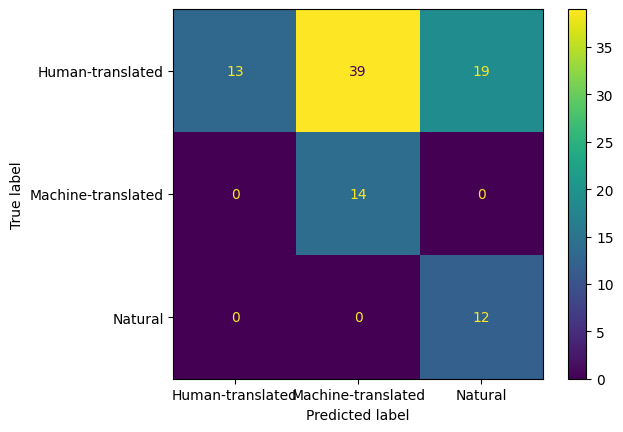

eng


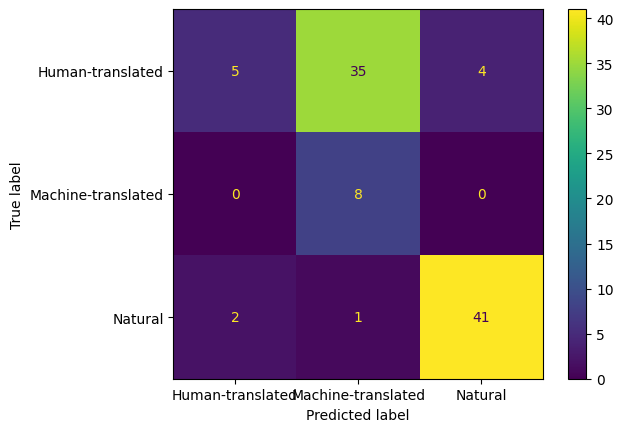

ind


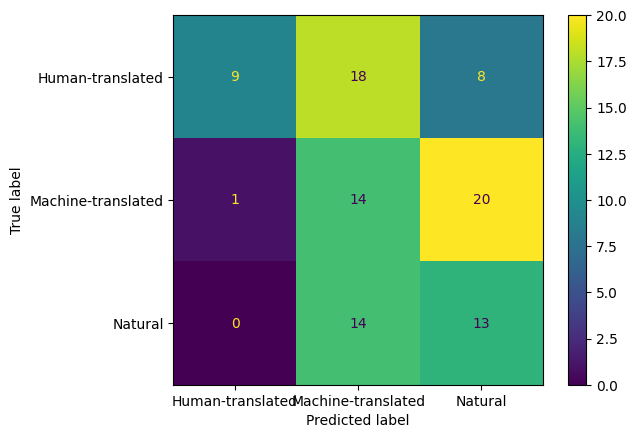

jav


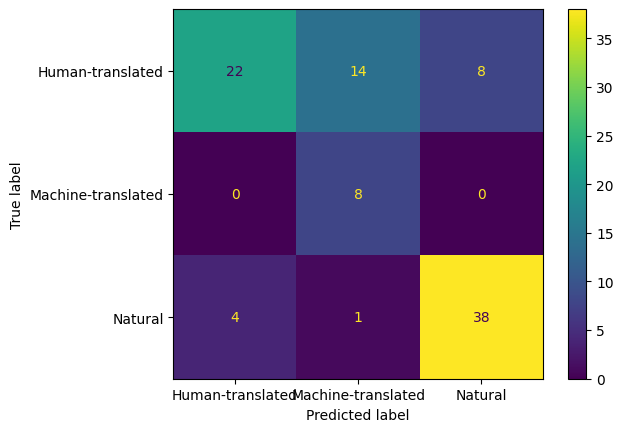

khm


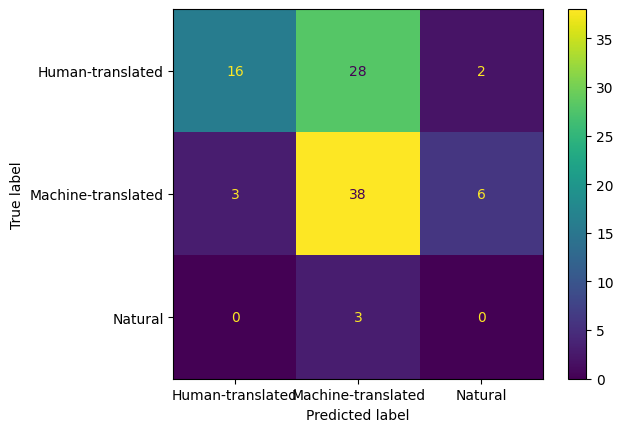

lao


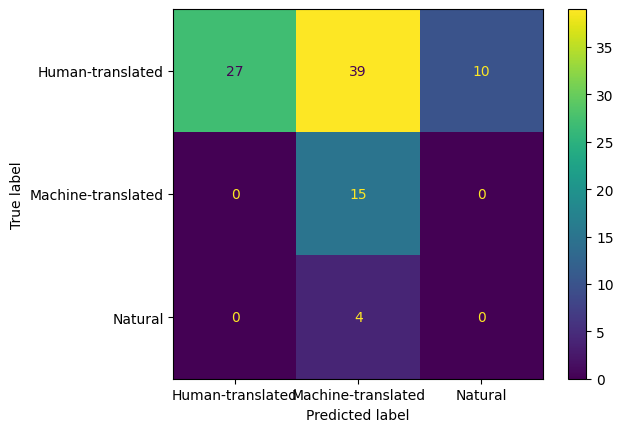

mya


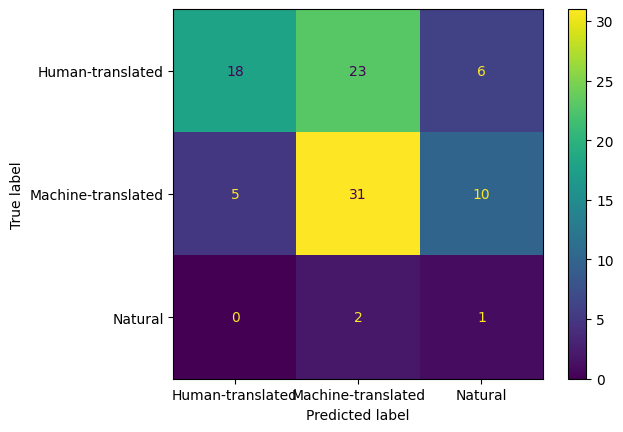

sun


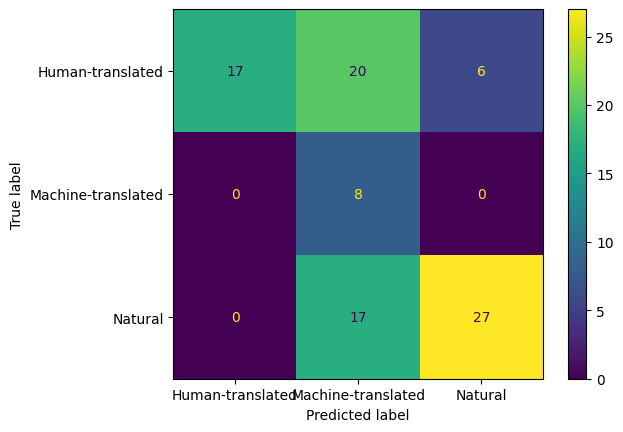

tgl


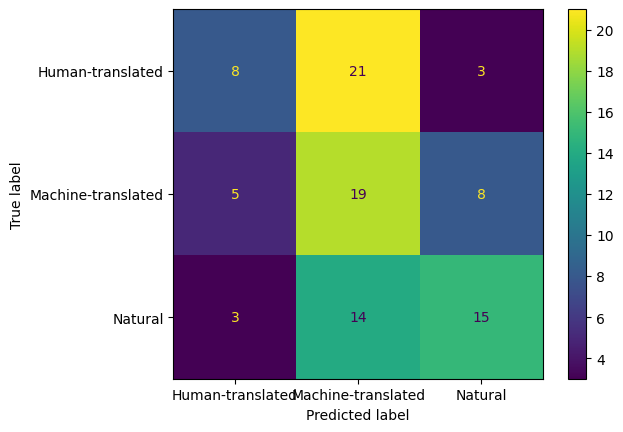

tha


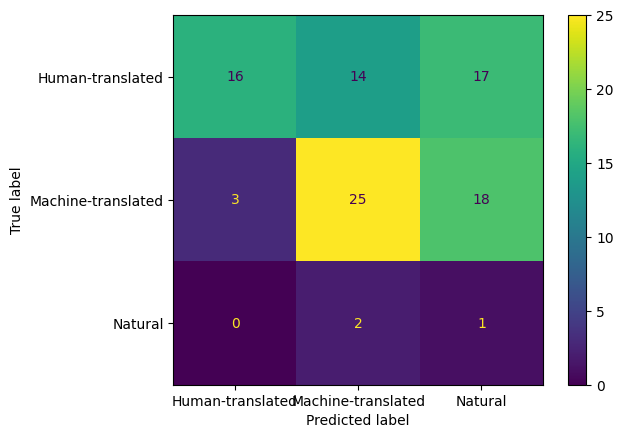

vie


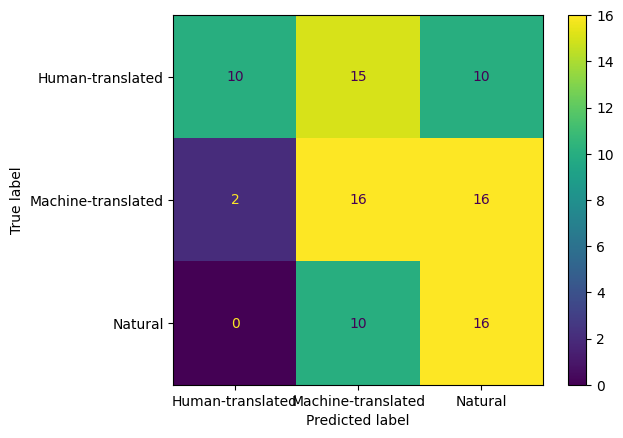

zsm


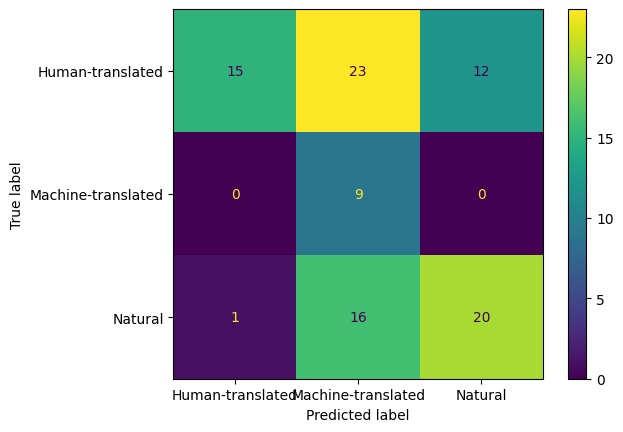

In [24]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
for lang in df['lang'].unique():
    tdf = df.loc[df['lang'] == lang,:]
    print(lang)
    cmd = ConfusionMatrixDisplay(
        confusion_matrix=confusion_matrix(tdf['label'], tdf['pred']) * 100,
        display_labels=label2name.values()
    )
    cmd.plot()
    plt.show()